# Dockless Scooter Data

In [1]:
import matplotlib, shapely, geopandas
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time, datetime
from sklearn.linear_model import LinearRegression

In [2]:
tract_to_name = {
    '000204': "Triangle",
    '000500': "North Campus",
    '000700': "South Campus",
    '000401': "East Campus",
    '000604': "Lower West Campus",
    '000603': "Upper West Campus",
    '000601': "Campus"
}

tract_to_index = {
    '000204': 0,
    '000500': 1,
    '000700': 2,
    '000401': 3,
    '000604': 4,
    '000603': 5,
    '000601': 6,
}

oncampus  = ['000601']
offcampus = ['000204', '000500', '000700', '000401', '000604', '000603']

In [5]:
scooter_data = pd.read_csv('../data/Dockless_Vehicle_Trips.csv')
austin_data = austin = geopandas.GeoDataFrame.from_file('../data/census_tracts_2010_msa/census_tracts_2010_msa.shp')

/Users/sanjayyepuri/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Dropping the first 6 digits of the tract start and end ids and converting to a numerical type.

In [6]:
scooter_data = scooter_data.dropna(subset=['Census Tract Start'])
                                   
scooter_data.sample(5)

,ID,Device ID,Vehicle Type,Trip Duration,Trip Distance,Start Time,End Time,Modified Date,Month,Hour,Day of Week,Council District (Start),Council District (End),Year,Census Tract Start,Census Tract End
596232,f5c434b3-60a3-4937-bbab-bc7e6d5ad02f,1a80a120-ae9d-4a2d-9392-774429086f18,scooter,313.0,1313.0,12/15/2018 08:30:00 AM,12/15/2018 08:30:00 AM,04/17/2019 02:28:50 AM,12.0,8.0,6.0,9.0,9.0,2018.0,48453000603,48453000601
1510426,11248719-24fa-4b56-8118-8bec26707ce6,c5a230c9-7e80-4464-862f-f2b23f61d6d3,scooter,282.0,656.0,03/22/2019 03:45:00 PM,03/22/2019 03:45:00 PM,04/17/2019 02:06:00 PM,3.0,15.0,5.0,9.0,9.0,2019.0,48453001100,48453001100
242143,1e9cbc25-e212-4f28-a587-8f115c2daf24,ea54b804-cc7f-434e-bdc4-e0606e54f5e6,scooter,496.0,0.0,03/01/2019 02:15:00 PM,03/01/2019 02:30:00 PM,04/25/2019 02:25:26 PM,3.0,14.0,5.0,1.0,1.0,2019.0,48453000804,48453000802
2793758,fc29301d-b7ec-473d-8339-e8d87ceaf846,6794736b-3aec-47cc-a624-670be57a7619,scooter,847.0,1512.0,12/22/2018 09:45:00 PM,12/22/2018 10:00:00 PM,04/17/2019 02:30:05 AM,12.0,21.0,6.0,9.0,9.0,2018.0,48453001100,48453001100
2894377,edfe53b3-7725-4de5-8ca7-eaac812b37a0,e6e52e51-d502-438d-ac7d-f2f6fb78a14b,scooter,168.0,0.0,02/17/2019 04:00:00 PM,02/17/2019 04:00:00 PM,04/17/2019 01:58:01 PM,2.0,16.0,0.0,9.0,9.0,2019.0,48453000604,48453000604


In [7]:
scooter_data = scooter_data[scooter_data['Census Tract Start'] != 'OUT_OF_BOUNDS']
scooter_data = scooter_data[scooter_data['Census Tract End'] != 'OUT_OF_BOUNDS']
scooter_data['Census Tract Start'] = pd.to_numeric(scooter_data['Census Tract Start'])
scooter_data['Census Tract End'] = pd.to_numeric(scooter_data['Census Tract End'])

In [8]:
def tract_to_trunk(tract):
    return "%06d" % (int(tract) % 1000000)

scooter_data['tract_start'] = scooter_data['Census Tract Start'].apply(tract_to_trunk)
scooter_data['tract_end'] = scooter_data['Census Tract End'].apply(tract_to_trunk)

In [9]:

scooter_data_starting = scooter_data[scooter_data['tract_start'].isin(oncampus + offcampus)]
scooter_data_ending   = scooter_data[scooter_data['tract_end'].isin(oncampus + offcampus)]

In [11]:
scooter_data_raw = pd.read_csv('../data/Dockless_Vehicle_Trips.csv')
scooter_data_raw.shape

/Users/sanjayyepuri/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(4561813, 16)

In [12]:
100 * (scooter_data_starting.shape[0] / scooter_data_raw.shape[0])

31.847052915145795

In [13]:
start_freqs = scooter_data_starting.groupby(['tract_start'])['tract_start'].agg('count').to_frame('count').reset_index()
start_data = geopandas.GeoDataFrame(pd.merge(start_freqs, austin_data, how='inner', left_on=['tract_start'], right_on=['TRACTCE10']))
start_data.head()

,tract_start,count,TRACTCE10,SUM_totpop,SUM_white,SUM_black,SUM_hispan,SUM_asian,SUM_other,SUM_multi,...,SUM_AGE651,SUM_AGE_65,SUM_AGE75_,SUM_AGE80_,SUM_AGE_85,SUM_FAMSWC,SUM_POP_IN,SUM_FAMILI,SUM_NONFAM,geometry
0,000204,24339,000204,3009.0,2396.0,43.0,323.0,161.0,8.0,78.0,...,21.0,80.0,27.0,20.0,26.0,234.0,56.0,495.0,1101.0,"POLYGON ((3114760.420262146 10081981.02697965,..."
1,000401,111638,000401,3574.0,2446.0,128.0,445.0,439.0,14.0,102.0,...,26.0,86.0,24.0,19.0,19.0,159.0,195.0,442.0,1288.0,"POLYGON ((3119875.384202184 10081103.12966995,..."
2,000500,43637,000500,4518.0,3305.0,67.0,545.0,464.0,18.0,119.0,...,37.0,101.0,13.0,11.0,15.0,147.0,77.0,430.0,2110.0,"POLYGON ((3117812.349419988 10078757.10780583,..."
3,000601,506146,000601,9207.0,4491.0,494.0,1972.0,1943.0,12.0,295.0,...,1.0,2.0,0.0,0.0,0.0,11.0,8396.0,44.0,389.0,"POLYGON ((3116530.436981633 10075208.93904213,..."
4,000603,342530,000603,7793.0,5121.0,149.0,972.0,1351.0,22.0,178.0,...,5.0,14.0,2.0,0.0,1.0,17.0,821.0,209.0,3027.0,"POLYGON ((3114630.355919199 10079462.03781622,..."


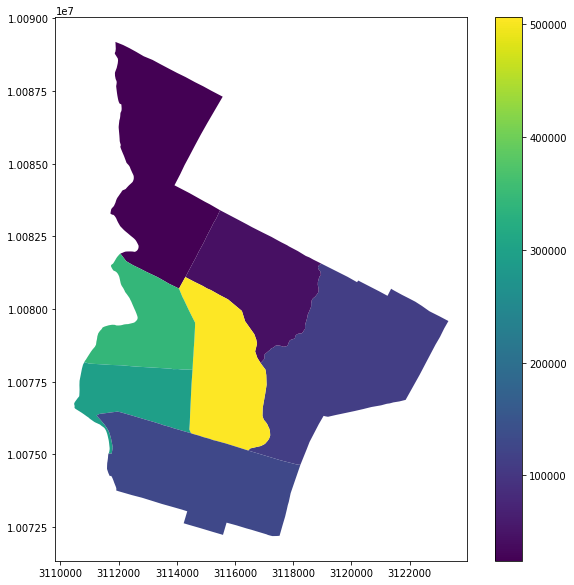

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
start_data.plot(column='count', ax=ax, legend=True)

In [15]:
end_freqs = scooter_data_ending.groupby(['tract_end'])['tract_end'].agg('count').to_frame('count').reset_index()
end_data = geopandas.GeoDataFrame(pd.merge(end_freqs, austin_data, how='inner', left_on=['tract_end'], right_on=['TRACTCE10']))
end_data.head()

,tract_end,count,TRACTCE10,SUM_totpop,SUM_white,SUM_black,SUM_hispan,SUM_asian,SUM_other,SUM_multi,...,SUM_AGE651,SUM_AGE_65,SUM_AGE75_,SUM_AGE80_,SUM_AGE_85,SUM_FAMSWC,SUM_POP_IN,SUM_FAMILI,SUM_NONFAM,geometry
0,000204,25858,000204,3009.0,2396.0,43.0,323.0,161.0,8.0,78.0,...,21.0,80.0,27.0,20.0,26.0,234.0,56.0,495.0,1101.0,"POLYGON ((3114760.420262146 10081981.02697965,..."
1,000401,119443,000401,3574.0,2446.0,128.0,445.0,439.0,14.0,102.0,...,26.0,86.0,24.0,19.0,19.0,159.0,195.0,442.0,1288.0,"POLYGON ((3119875.384202184 10081103.12966995,..."
2,000500,45669,000500,4518.0,3305.0,67.0,545.0,464.0,18.0,119.0,...,37.0,101.0,13.0,11.0,15.0,147.0,77.0,430.0,2110.0,"POLYGON ((3117812.349419988 10078757.10780583,..."
3,000601,547597,000601,9207.0,4491.0,494.0,1972.0,1943.0,12.0,295.0,...,1.0,2.0,0.0,0.0,0.0,11.0,8396.0,44.0,389.0,"POLYGON ((3116530.436981633 10075208.93904213,..."
4,000603,306894,000603,7793.0,5121.0,149.0,972.0,1351.0,22.0,178.0,...,5.0,14.0,2.0,0.0,1.0,17.0,821.0,209.0,3027.0,"POLYGON ((3114630.355919199 10079462.03781622,..."


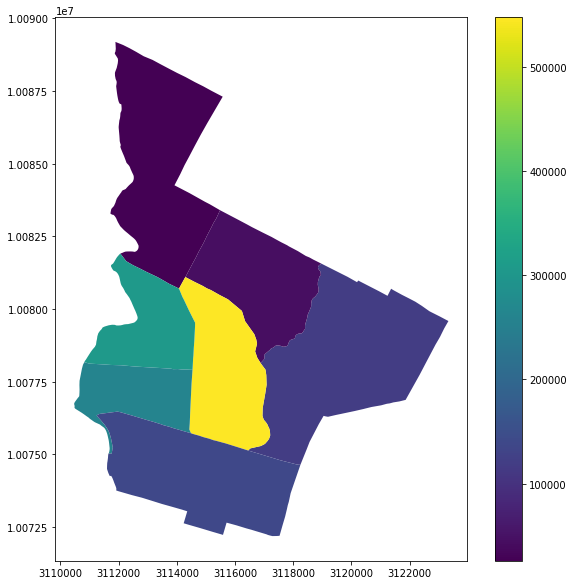

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
end_data.plot(column='count', ax=ax, legend=True)

In [17]:
print(scooter_data_starting.shape, scooter_data_ending.shape)
scooter_data_starting.head()
merged_data =scooter_data_starting[scooter_data_starting['ID'].isin(scooter_data_ending['ID'])]
merged_data.shape

(1452803, 18) (1446243, 18)


(1327537, 18)

In [18]:
merged_start_freqs = merged_data.groupby(['tract_start'])['tract_start'].agg('count').to_frame('count').reset_index()
merged_end_freqs = merged_data.groupby(['tract_end'])['tract_end'].agg('count').to_frame('count').reset_index()

merged_start_data = geopandas.GeoDataFrame(pd.merge(merged_start_freqs, austin_data, how='inner', left_on=['tract_start'], right_on=['TRACTCE10']))
merged_end_data = geopandas.GeoDataFrame(pd.merge(merged_end_freqs, austin_data, how='inner', left_on=['tract_end'], right_on=['TRACTCE10']))

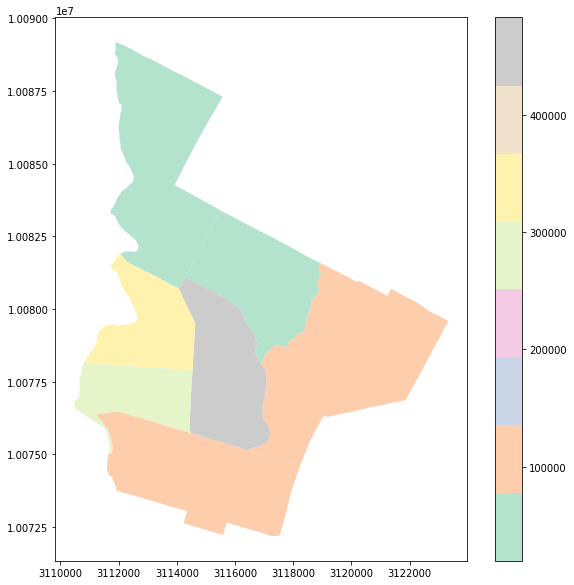

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
merged_start_data.plot(column='count', ax=ax, legend=True, cmap='Pastel2')

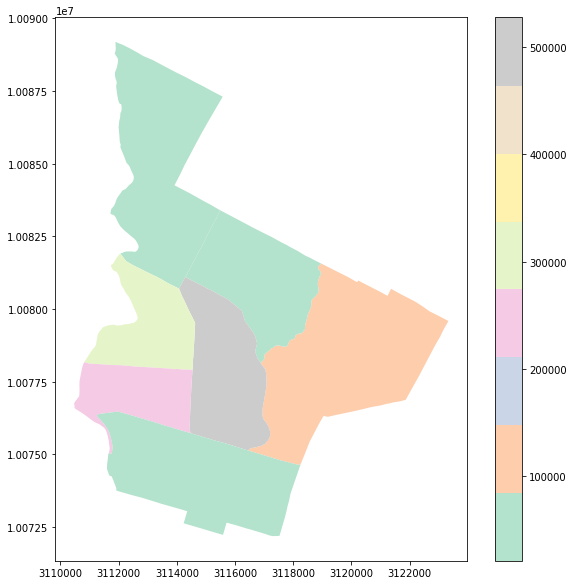

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
merged_end_data.plot(column='count', ax=ax, legend=True, cmap='Pastel2')

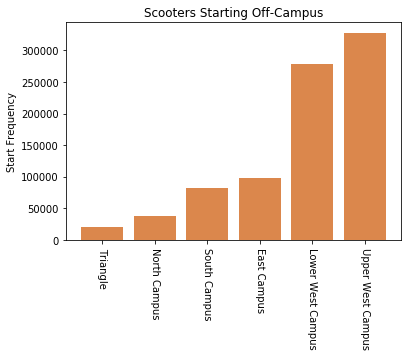

In [21]:
total = 0
d = []
d_norm = []
labels = []
for loc in offcampus:
    freq = merged_start_freqs[merged_start_freqs["tract_start"] == loc]["count"].iloc[0]
    total += freq
    labels.append(tract_to_name[str(loc)])
    d.append(freq)

for loc in offcampus:
    freq = merged_start_freqs[merged_start_freqs["tract_start"] == loc]["count"].iloc[0]
    d_norm.append(freq / total)

plt.bar(labels, d, align='center', color='#cc5500', alpha=0.7)
plt.ylabel('Start Frequency')
plt.xticks(rotation=-90)
plt.title('Scooters Starting Off-Campus')

plt.show()

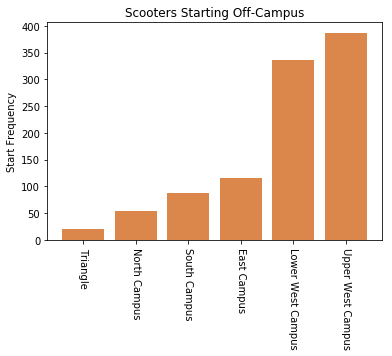

In [22]:
# randomly sample a location :-)
freqqq = [0]*len(offcampus)
for _ in range(1000):
    freqqq[tract_to_index[np.random.choice(offcampus, p=d_norm)]] += 1

plt.bar(labels, freqqq, align='center', color='#cc5500', alpha=0.7)
plt.ylabel('Start Frequency')
plt.xticks(rotation=-90)
plt.title('Scooters Starting Off-Campus')

plt.show()

    Hour  count
14  14.0  10587
16  16.0  10238
15  15.0  10230
    Hour  count
12  12.0  17467
13  13.0  16119
14  14.0  15501
    Hour  count
12  12.0  21069
15  15.0  18788
9    9.0  17597
    Hour  count
12  12.0  19046
13  13.0  17778
14  14.0  17001
    Hour  count
12  12.0  22433
15  15.0  19431
9    9.0  18762
    Hour  count
12  12.0  18290
13  13.0  17581
11  11.0  16597
    Hour  count
16  16.0  14656
15  15.0  14553
14  14.0  14009


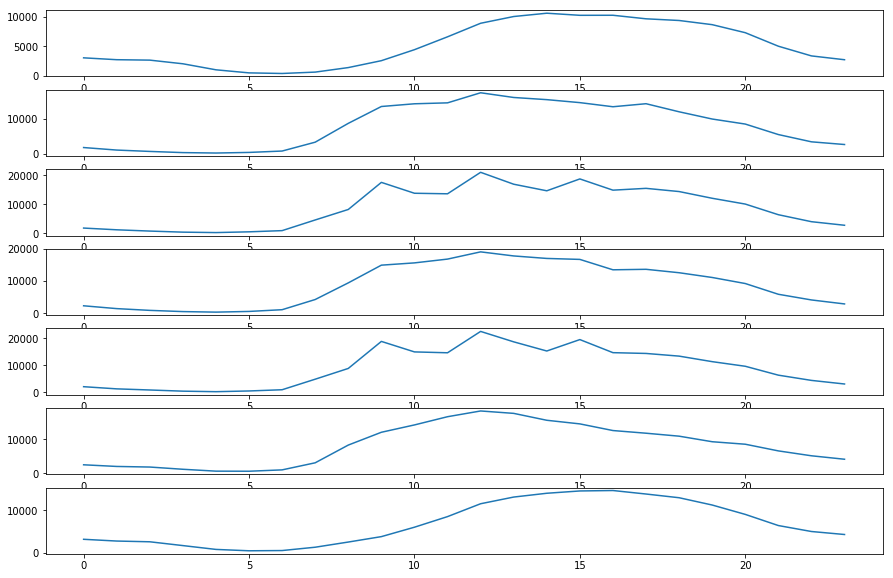

In [23]:
fig, ax = plt.subplots(7, 1,figsize=(15, 10))
for i in range(7): # 0 = sunday, 6 = saturday
    time_freq = merged_data[merged_data['Day of Week'] == i].groupby(['Hour'])['Hour'].agg('count').to_frame('count').reset_index()
    ax[i].plot(time_freq['Hour'], time_freq['count'])
    print(time_freq.nlargest(3, "count"))

In [24]:
merged_data['Start Time'] = pd.to_datetime(merged_data['Start Time'], format="%m/%d/%Y %I:%M:%S %p")
merged_data['End Time']   = pd.to_datetime(merged_data['End Time'],   format="%m/%d/%Y %I:%M:%S %p")

/Users/sanjayyepuri/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/sanjayyepuri/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
merged_data['Start Time'].sample()

2107020   2018-10-27 13:15:00
Name: Start Time, dtype: datetime64[ns]

In [26]:
def to_decimal(strtime):
    hour, minute = map(int, strtime.strftime("%H:%M").split(':'))
    return hour + (minute / 60)

merged_data['start_hour_decimal'] = merged_data['Start Time'].apply(to_decimal)
merged_data['end_hour_decimal'] = merged_data['End Time'].apply(to_decimal)

/Users/sanjayyepuri/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/sanjayyepuri/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
merged_data.head()

,ID,Device ID,Vehicle Type,Trip Duration,Trip Distance,Start Time,End Time,Modified Date,Month,Hour,Day of Week,Council District (Start),Council District (End),Year,Census Tract Start,Census Tract End,tract_start,tract_end,start_hour_decimal,end_hour_decimal
2,aa27d854-9f27-456e-ae49-f268a9b2b533,6b90a827-60a1-47ad-94a4-d33654dbd50d,scooter,170.0,0.0,2019-04-29 17:30:00,2019-04-29 17:30:00,04/30/2019 06:45:17 AM,4.0,17.0,1.0,9.0,9.0,2019.0,4.845300e+10,4.845300e+10,000601,000601,17.5,17.50
3,b7c9f133-966b-46f1-91ce-2682ce7fcf50,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,90.0,0.0,2019-04-29 17:30:00,2019-04-29 17:30:00,04/30/2019 06:45:17 AM,4.0,17.0,1.0,9.0,9.0,2019.0,4.845300e+10,4.845300e+10,000601,000601,17.5,17.50
5,cd442fb9-058f-46a7-af90-b4adb56fd163,1653cf10-75f5-4934-a9d9-c8d43ade67a9,scooter,438.0,1815.0,2019-04-29 17:30:00,2019-04-29 17:45:00,04/30/2019 06:45:17 AM,4.0,17.0,1.0,9.0,9.0,2019.0,4.845300e+10,4.845300e+10,000601,000500,17.5,17.75
7,b7df9ed5-61ae-40ca-9b7e-0ffa1d092b79,09b2c7b8-6631-4999-85d5-4273b4c98f3a,scooter,153.0,0.0,2019-04-29 17:00:00,2019-04-29 17:00:00,04/30/2019 06:45:17 AM,4.0,17.0,1.0,9.0,9.0,2019.0,4.845300e+10,4.845300e+10,000604,000604,17.0,17.00
11,7211c488-c0ad-40a9-8a07-4326dbb56c6f,9e6ae0d2-76a0-4e24-8f6e-8d724564b638,scooter,432.0,1698.0,2019-04-29 17:30:00,2019-04-29 17:30:00,04/30/2019 06:45:17 AM,4.0,17.0,1.0,9.0,9.0,2019.0,4.845300e+10,4.845300e+10,000601,000603,17.5,17.50


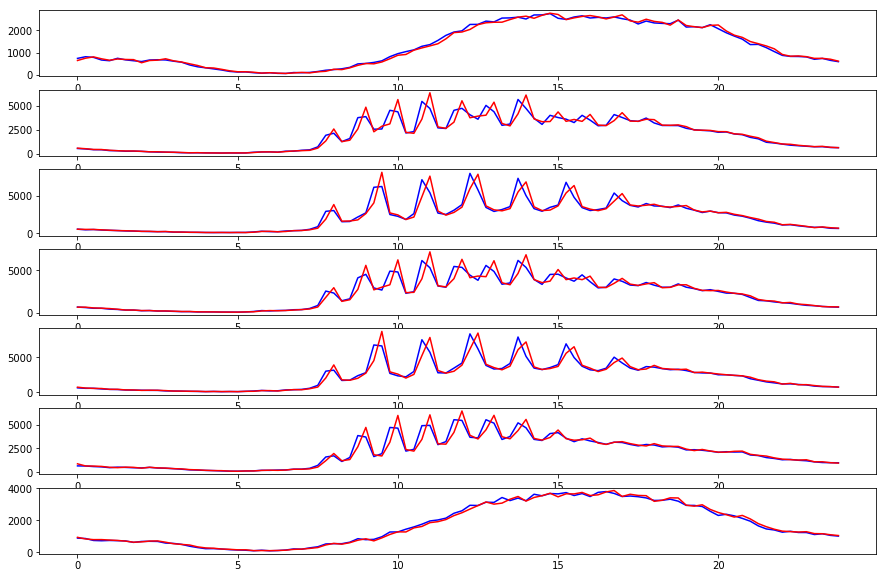

In [28]:
fig, ax = plt.subplots(7, 1,figsize=(15, 10))
for i in range(7): # 0 = sunday, 6 = saturday
    start_time_freq = merged_data[merged_data['Day of Week'] == i].groupby(['start_hour_decimal'])['start_hour_decimal'].agg('count').to_frame('count').reset_index()
    end_time_freq   = merged_data[merged_data['Day of Week'] == i].groupby(['end_hour_decimal'])['end_hour_decimal'].agg('count').to_frame('count').reset_index()
    ax[i].plot(start_time_freq['start_hour_decimal'], start_time_freq['count'], c="blue")
    ax[i].plot(end_time_freq['end_hour_decimal'], end_time_freq['count'], c="red")
#     print(time_freq.nlargest(3, "count"))

In [29]:
# P(start_time)
def get_start_time_distribution(class_time):
    first_time      = class_time - 0.50
    second_time     = class_time - 0.25
    
    start_time_freq = merged_data[merged_data['Day of Week'] == 3].groupby(['start_hour_decimal'])['start_hour_decimal'].agg('count').to_frame('count').reset_index()
    first  = int(start_time_freq[start_time_freq['start_hour_decimal'] == first_time]['count'].iloc[0])
    second = int(start_time_freq[start_time_freq['start_hour_decimal'] == second_time]['count'].iloc[0])
    third  = int(start_time_freq[start_time_freq['start_hour_decimal'] == class_time]['count'].iloc[0])
    
    first_ln, second_ln, third_ln = np.log(first), np.log(second), np.log(third)
    first_piecewise  = LinearRegression().fit(np.array([0,  15]).reshape((-1, 1)), [first,  second])
    second_piecewise = LinearRegression().fit(np.array([15, 30]).reshape((-1, 1)), [second_ln, third_ln])
    
    distribution = {}
    total = 0.0
    for minute in range(0, 30):
        if minute < 15:
            total += first_piecewise.predict(np.array([minute]).reshape(1, -1))[0]
        else:
            total += np.exp(second_piecewise.predict(np.array([minute]).reshape(1, -1))[0])
            
    for minute in range(0, 30):
        t = first_time + (minute / 60)
        if minute < 15:
            distribution[t] = first_piecewise.predict(np.array([minute]).reshape(1, -1))[0]
        else:
            distribution[t] = np.exp(second_piecewise.predict(np.array([minute]).reshape(1, -1))[0])

        distribution[t] /= total
        
    squished_dist = {first_time: 0.0, second_time: 0.0}
    for minute in range(0, 30):
        t = first_time + (minute / 60)
        if minute < 15:
            squished_dist[first_time] += distribution[t]
        else:
            squished_dist[second_time] += distribution[t]

    return squished_dist

distribution = get_start_time_distribution(8.0)
print(distribution)

distribution = get_start_time_distribution(9.0)
print(distribution)

{7.5: 0.402222758962476, 7.75: 0.5977772410375242}
{8.5: 0.3934300981890413, 8.75: 0.6065699018109585}


In [34]:
# P(distance | start_time)
def get_distance_distribution(start_time):
    distances_given_start = merged_data[merged_data["start_hour_decimal"] == start_time]
    distances_given_start = distances_given_start[(distances_given_start['Trip Distance'] > 50) & (distances_given_start['Trip Distance'] < 2000)].sort_values(by=['Trip Distance'])
    distances_freq = distances_given_start.groupby(['Trip Distance'])['Trip Distance'].agg('count').to_frame('count').reset_index()

    # avg pool/smooth data
    distances_freq_pooled = {}
    total = 0.0
    for mid in range(55, 1906, 10):
        window = distances_freq[distances_freq['Trip Distance'].isin(list(range(mid, mid + 10)))]
        val = window['count'].mean()
        distances_freq_pooled[mid] = val
        total += val
    
   
    
    for mid in range(55, 1906, 10):
        distances_freq_pooled[mid] /= total
        
    return distances_freq_pooled

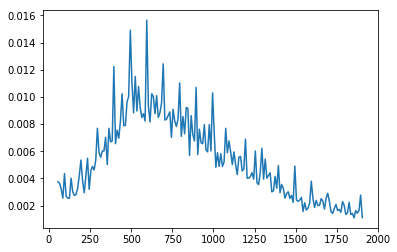

In [31]:
dist = get_distance_distribution(9.0)
x, y = zip(*sorted(dist.items()))

plt.plot(x, y)
plt.show()

In [172]:
from shapely.geometry import Point
from utils import convert_from_lat_long
from endloc_classtime import building_coords

## We will need this data when we implement this for real 
geometries = austin_data[austin_data['TRACTCE10'].isin(tract_to_name.keys())]['geometry']

# P(start_region | class_location, distance)
def get_start_region_distribution(class_loc, dist):
    given_distance = merged_data[merged_data['Trip Distance'].isin(range(dist-10, dist+10))]

    # offcampus -> oncampus
    correct_endpoints_forward = given_distance[given_distance['tract_start'].isin(offcampus)]
    correct_endpoints_forward = correct_endpoints_forward[correct_endpoints_forward['tract_end'].isin(oncampus)]

    # oncampus -> offcampus
    correct_endpoints_backward = given_distance[given_distance['tract_start'].isin(oncampus)]
    correct_endpoints_backward = correct_endpoints_backward[correct_endpoints_backward['tract_end'].isin(offcampus)]
    correct_endpoints_backward.rename(columns={'tract_start': 'tract_end', 'tract_end': 'tract_start'}, inplace=True)

    # all offcampus -> oncampus
    correct_endpoints = pd.concat([correct_endpoints_forward, correct_endpoints_backward], sort=False)

#     print(len(correct_endpoints))
    start_tract_freq = correct_endpoints.groupby(['tract_start'])['tract_start'].agg('count').to_frame('count').reset_index()
    
    lat, long = building_coords[class_loc]
    point = Point(lat, long)
    
    total = 0
    distribution = {}
    for i in range(len(start_tract_freq)):
        curr_tract = start_tract_freq.iloc()[i]['tract_start'] # offcampus -> oncampus
            
        geometry = austin_data[austin_data['TRACTCE10'] == str(curr_tract)]['geometry'].iloc()[0]

        if geometry.distance(convert_from_lat_long(point.y, point.x))*0.3048 > dist:   
            distribution[curr_tract] = 0.0
        else:
             distribution[curr_tract] = float(start_tract_freq.iloc()[i]['count'])
        
        total += distribution[curr_tract]
        
    total = float(total)
    
    if total == 0:
        return distribution 
    
    for i in distribution.keys():
        distribution[i] /= total
    
    return distribution

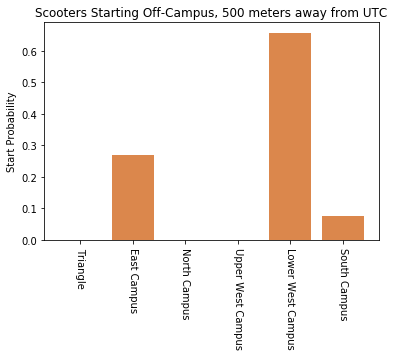

In [202]:
freqqq = []
labels = []
building = 'UTC'
distance = 500
dist = get_start_region_distribution(building, distance)
for tract, prob in dist.items():
    freqqq.append(prob)
    labels.append(tract_to_name[tract])

plt.bar(labels, freqqq, align='center', color='#cc5500', alpha=0.7)
plt.ylabel('Start Probability')
plt.xticks(rotation=-90)
plt.title('Scooters Starting Off-Campus, %d meters away from %s' % (distance, building))

plt.show()

# plt.bar(labels, freqqq, align='center', color='#cc5500', alpha=0.7)
# plt.ylabel('Start Frequency')
# plt.xticks(rotation=-90)
# plt.title('Scooters Starting Off-Campus')

# plt.show()

In [216]:
def get_building(s):
    return s.split(" ")[0]

def get_start_location_distribution(class_time):
    dist = {} # dictionary for {class_time : {building : probability_distr}}
    data = pd.read_csv('../data/Course_Info.csv')

    data['building'] = data['Room'].apply(get_building)
    data = data.groupby(['Begin Time'])
    
    df = data.get_group(class_time)

    df = df.groupby('building')['building'].agg('count').to_frame('count').reset_index()
    total_classes = 0.0
    for i in range(len(df)):
        room = df.iloc()[i]['building']
        count = df.iloc()[i]['count']
        dist[room] = count
        total_classes += count
        
    for key, value in dist.items():
        dist[key] /= total_classes

    return dist

print(get_start_location_distribution("9:00 AM"))

{'BTL': 0.030303030303030304, 'BUR': 0.06060606060606061, 'CBA': 0.030303030303030304, 'CPE': 0.030303030303030304, 'ECJ': 0.030303030303030304, 'ETC': 0.030303030303030304, 'GDC': 0.030303030303030304, 'MRH': 0.09090909090909091, 'PAI': 0.06060606060606061, 'PAR': 0.09090909090909091, 'RLM': 0.18181818181818182, 'SUT': 0.06060606060606061, 'UTC': 0.18181818181818182, 'WMB': 0.09090909090909091}
